### VGG16 CNN

 - Note: You need to use keras 2.1.4 (2.2 did not work for this part of the tutorial)

In [17]:
import numpy as np
from random import randint
from sklearn.preprocessing import MinMaxScaler

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
import itertools
import matplotlib.pyplot as plt


from utils import plot_confusion_matrix, plots

%matplotlib inline

In [16]:
train_path = 'cats-and-dogs/train'
valid_path = 'cats-and-dogs/valid'
test_path = 'cats-and-dogs/test'

In [85]:
train_batches = ImageDataGenerator().flow_from_directory(train_path , classes=['dog', 'cat'], batch_size=10, target_size=(224, 224))
valid_batches = ImageDataGenerator().flow_from_directory(valid_path , classes=['dog', 'cat'], batch_size=2, target_size=(224, 224))
test_batches = ImageDataGenerator().flow_from_directory(test_path , classes=['dog', 'cat'], batch_size=10, target_size=(224, 224))

Found 800 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


### Just an util function to let us see the images

In [57]:
imgs, labels = next(train_batches)

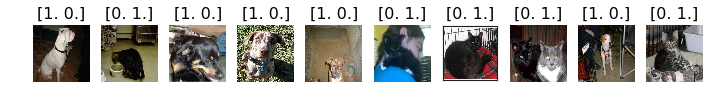

In [58]:
plots(imgs, titles=labels)

### Build VGG16 model



In [59]:
vgg16_model = keras.applications.vgg16.VGG16()

In [60]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In the last layer it says: **predictions (Dense)          (None, 1000)**
That means it's able to classify in 1000 categories. But we only want 2.
So we will create a brand new model based on this one.

In [61]:
model = Sequential()
## iterate over all layers except for the last one, and add them to our new Sequential model


for layer in vgg16_model.layers[:-1]:
    layer.trainable = False 
    # ^ Means, it won't ever update its weights on training (since it's already trained)
    model.add(layer)

## and we add a last layer
model.add(Dense(2, activation='softmax'))
    
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Train

In [62]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(train_batches,  
          steps_per_epoch=6, # Number of train images / batch_side
          validation_data=valid_batches,
          validation_steps=3, # Number of valid images / batch_side
          epochs=5, verbose=2)

Epoch 1/5
 - 18s - loss: 0.6373 - acc: 0.6667 - val_loss: 1.0567 - val_acc: 0.6667
Epoch 2/5
 - 18s - loss: 0.5852 - acc: 0.7167 - val_loss: 1.0131 - val_acc: 0.8333
Epoch 3/5
 - 19s - loss: 0.5019 - acc: 0.7500 - val_loss: 0.7990 - val_acc: 0.8333
Epoch 4/5
 - 18s - loss: 0.5133 - acc: 0.7667 - val_loss: 0.5501 - val_acc: 0.8333
Epoch 5/5
 - 17s - loss: 0.4396 - acc: 0.8333 - val_loss: 0.3864 - val_acc: 0.8333


**Much better results! ^**

### Predict

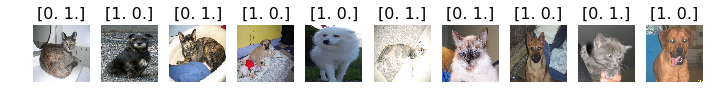

In [86]:
## [1,0] -> Dog,     [0, 1] -> Cat
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [87]:
## we make the labels to be 1 for dog and 0 for cat. 

test_labels = test_labels[:,0]
test_labels

array([0., 1., 0., 1., 1., 0., 0., 1., 0., 1.], dtype=float32)

In [88]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)
predictions

array([[3.9922311e-03, 9.9600780e-01],
       [8.0827147e-01, 1.9172855e-01],
       [2.6037416e-01, 7.3962581e-01],
       [5.6592286e-01, 4.3407717e-01],
       [1.2849550e-01, 8.7150449e-01],
       [1.1721125e-01, 8.8278872e-01],
       [8.5399896e-03, 9.9145997e-01],
       [4.0869051e-01, 5.9130949e-01],
       [7.3247962e-03, 9.9267524e-01],
       [9.9994278e-01, 5.7234785e-05]], dtype=float32)

Confusion matrix, without normalization
[[5 0]
 [2 3]]


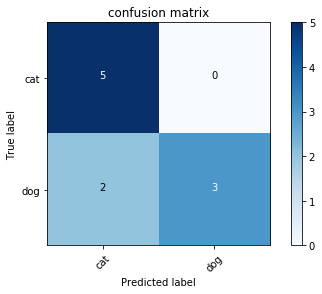

In [89]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))
plot_confusion_matrix(cm, ['cat', 'dog'])